In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from config import *
from sanity_functions import *

### Train

In [2]:
train = pd.read_csv(DATA_PATH / 'case_study_training.csv')
train.head()

,City,Website,Revenue,Status,Value
0,Harrisburg,https://www.paiolta.org/,"$25,000,001 to $100,000,000",Other,0
1,Santa Fe Springs,http://WWW.OXYHEALTH.COM,"$7,500,001 to $25,000,000",Private,0
2,Milford Mill,http://www.lsfrontiers.com/#xl_About:32Us,"$7,500,001 to $25,000,000",Non Profit,0
3,Harrisburg,http://www.wethepeoplepaaction.org/,"$1 to $500,000",Private,0
4,Boca Raton,https://hermanlaw.com/,"$500,001 to $7,500,000",Other,0


In [3]:
caract_df(train)

Nº rows: 2000
Nº columns: 5
Nº duplicated rows: 0

Nº of missings*:
(*) Before processing


In [4]:
data_info = pd.concat([pd.DataFrame(train.dtypes).T.rename(index={0:'column type'}),pd.DataFrame(train.isnull().sum()).T.rename(index={0:'nº nulls'}),
                       pd.DataFrame(train.isnull().sum()/train.shape[0]*100).T.
                      rename(index={0:'% nulls'}),pd.DataFrame(train.nunique()).T.rename(index={0:'nº unique values'})])

data_info

,City,Website,Revenue,Status,Value
column type,object,object,object,object,int64
nº nulls,0,0,0,0,0
% nulls,0.0,0.0,0.0,0.0,0.0
nº unique values,890,1993,7,3,2


In [5]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Value,2000.0,0.1165,0.320904,0.0,0.0,0.0,0.0,1.0


Mostrando as maiores categorias de 890


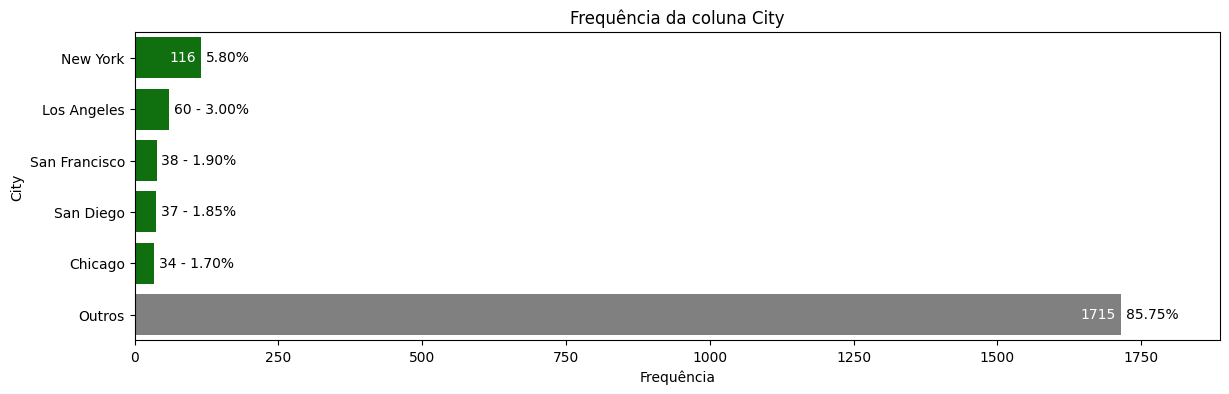

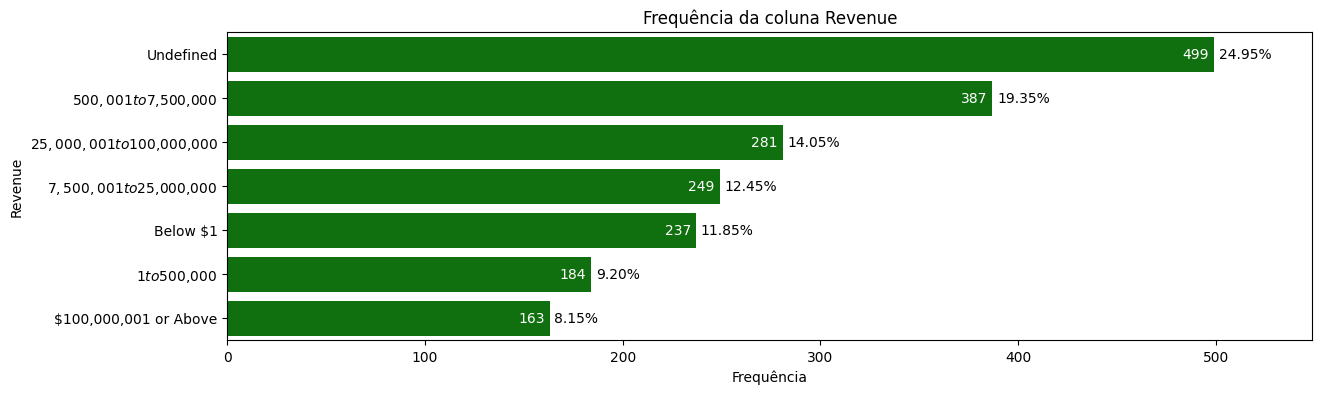

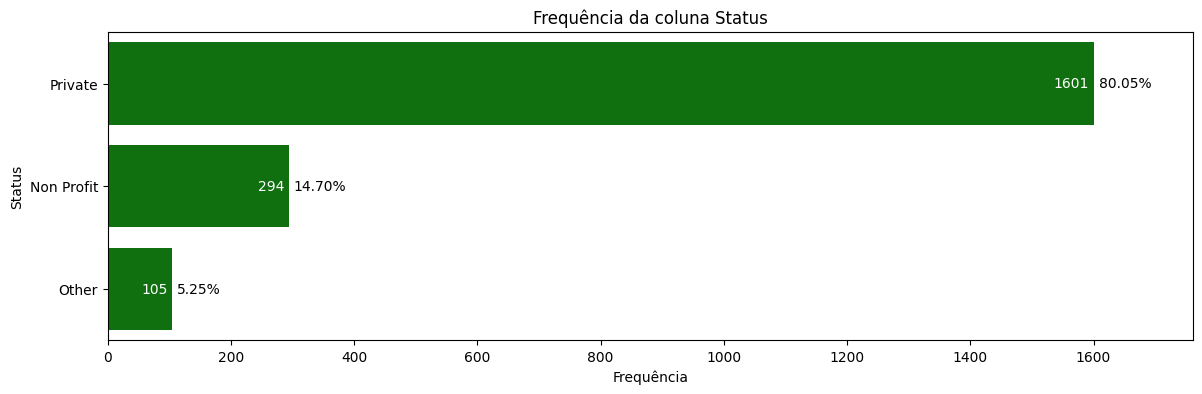

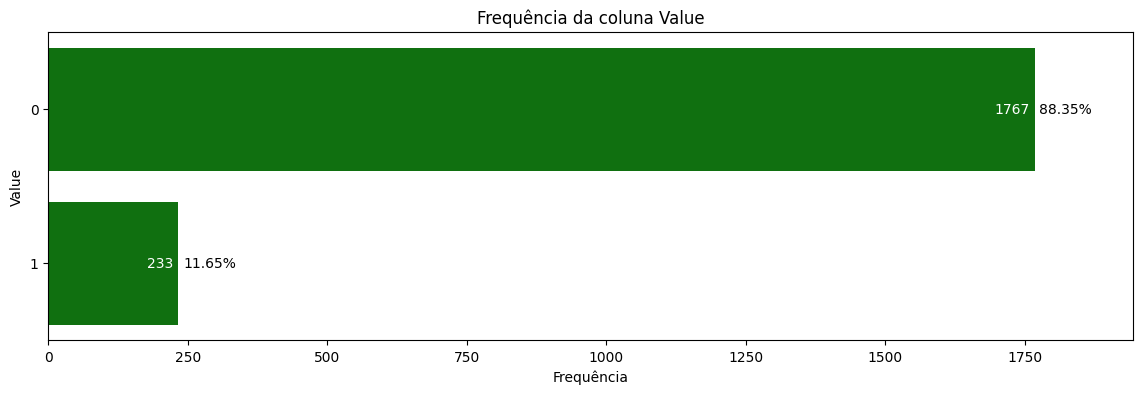

In [6]:
colunas_categoricas = ['City', 'Revenue', 'Status', 'Value']
for colunas in colunas_categoricas:
    barplot(train[colunas])

Número de outliers (excluídos): 0 (0.0% do total)
Número de registros considerados: 2000


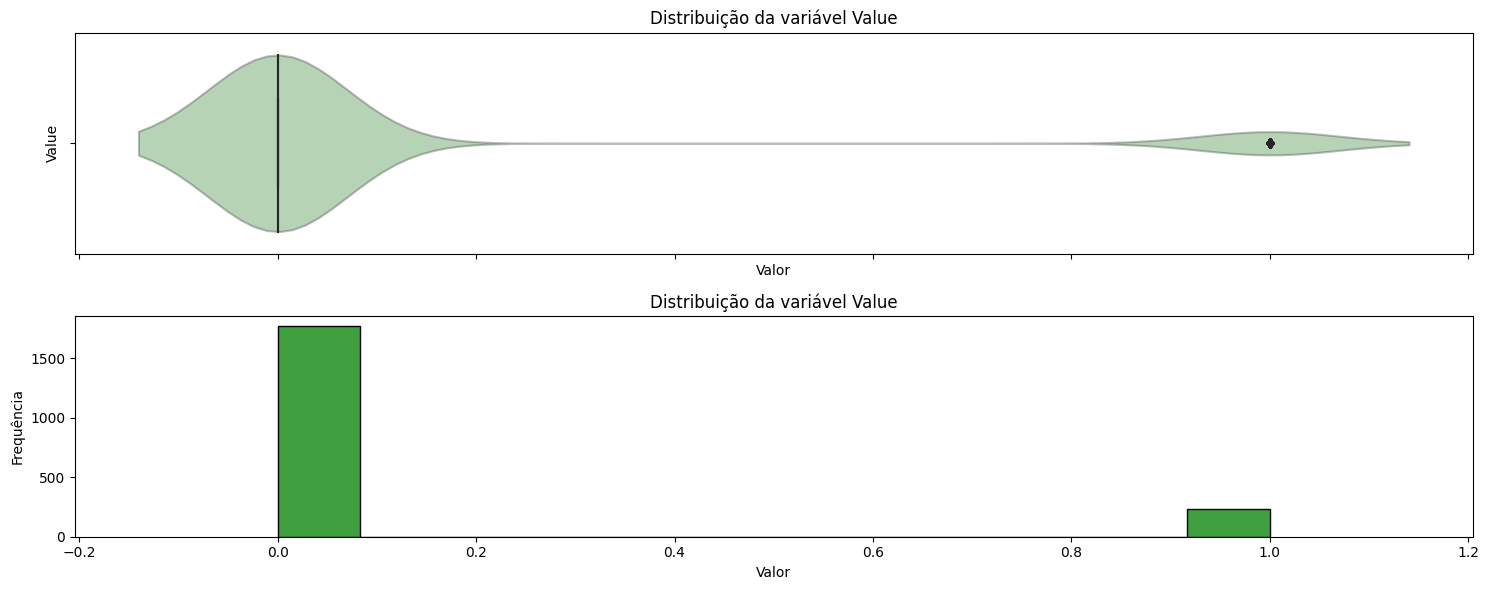

In [7]:
numeric_plot(train['Value'])

### Test

In [8]:
test = pd.read_csv(DATA_PATH / 'case_study_testing.csv')
test.head()

,City,Website,Revenue,Status,Value
0,Denver,https://mysunshare.com/,"$500,001 to $7,500,000",NaN,NaN
1,Yucca Valley,http://prototyp3.xyz,Undefined,NaN,NaN
2,New York,http://onyllc.com,"$7,500,001 to $25,000,000",NaN,NaN
3,Wilmington,http://www.nikangtx.com/,"$1 to $500,000",NaN,NaN
4,Kansas City,http://www.dtpizza.org,Undefined,NaN,NaN


In [9]:
caract_df(test)

Nº rows: 2000
Nº columns: 5
Nº duplicated rows: 0

Nº of missings*:
	Status: 2000 - 100.0%
	Value: 2000 - 100.0%
(*) Before processing


In [10]:
data_info = pd.concat([pd.DataFrame(test.dtypes).T.rename(index={0:'column type'}),pd.DataFrame(test.isnull().sum()).T.rename(index={0:'nº nulls'}),
                       pd.DataFrame(test.isnull().sum()/test.shape[0]*100).T.
                      rename(index={0:'% nulls'}),pd.DataFrame(test.nunique()).T.rename(index={0:'nº unique values'})])

data_info

,City,Website,Revenue,Status,Value
column type,object,object,object,float64,float64
nº nulls,0,0,0,2000,2000
% nulls,0.0,0.0,0.0,100.0,100.0
nº unique values,909,1997,7,0,0


Mostrando as maiores categorias de 909


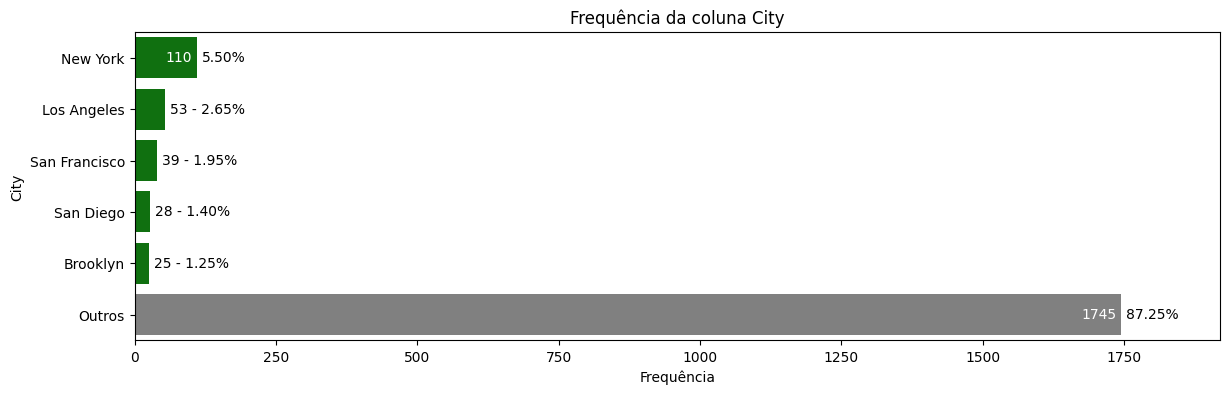

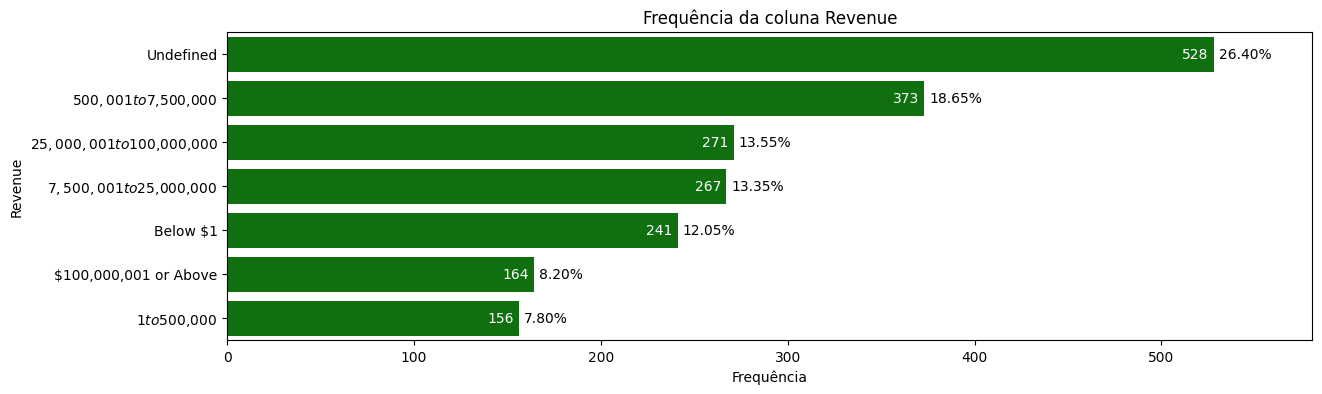

In [11]:
colunas_categoricas = ['City', 'Revenue']
for colunas in colunas_categoricas:
    barplot(test[colunas])

### Clustering

Since we already filled some values within the test dataset, I will change our train and test datasets in order to cluster only the remaining ones.

We first try to label the remaining "Status"

In [12]:
train_df = train.copy()
test_df = test.copy()

# Split the data into X (features) and y (labels)
X_train = train_df.drop(['Status', 'Value', 'Website'], axis=1)
y_train = train_df[['Status']]
X_test = test_df.drop(['Status', 'Value', 'Website'], axis=1)

# Define the OneHotEncoder for the categorical columns
ct = ColumnTransformer(
    [('encoder', OneHotEncoder(handle_unknown='ignore'), ['City', 'Revenue'])],
    remainder='passthrough')

# Define the pipeline with KMeans
pipeline = Pipeline([
    ('transform', ct),
    ('kmeans', KMeans(n_clusters=3, random_state=42))
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'kmeans__n_clusters': [3],
    'kmeans__init': ['k-means++', 'random'],
    'kmeans__max_iter': [100, 200, 300],
    'kmeans__tol': [0.0001, 0.001, 0.01]
}

# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Use the best model to predict missing 'Status' and 'Value' values in the test set
y_pred = grid_search.predict(X_test)

# Create a new dataframe with the predicted 'Status' and 'Value' values
result_df = pd.DataFrame(y_pred, columns=['Status'])
result_df = result_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
# Merge the original test dataframe with the predicted values dataframe using the index
test_df = pd.concat([test_df.drop(['Status'], axis=1), result_df], axis=1)

# Print the resulting dataframe with filled 'Status' and 'Value' values
print(test_df)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
               City                                            Website  \
0            Denver                            https://mysunshare.com/   
1      Yucca Valley                               http://prototyp3.xyz   
2          New York                                  http://onyllc.com   
3        Wilmington                           http://www.nikangtx.com/   
4       Kansas City                             http://www.dtpizza.org   
...             ...                                                ...   
1995          Miami                            https://swapglobal.com/   
1996        Concord                      https://www.kantumpharma.com/   
1997        Houston  https://www.mydna.life/gene-by-gene-familytree...   
1998  Santa Clarita                      http://www.blackknightllc.com   
1999         Tucson                              https://tetakawi.com/   

                          Revenue  Value  Status  

In [13]:
test_df

,City,Website,Revenue,Value,Status
0,Denver,https://mysunshare.com/,"$500,001 to $7,500,000",NaN,2
1,Yucca Valley,http://prototyp3.xyz,Undefined,NaN,1
2,New York,http://onyllc.com,"$7,500,001 to $25,000,000",NaN,0
3,Wilmington,http://www.nikangtx.com/,"$1 to $500,000",NaN,0
4,Kansas City,http://www.dtpizza.org,Undefined,NaN,1
...,...,...,...,...,...
1995,Miami,https://swapglobal.com/,Undefined,NaN,1
1996,Concord,https://www.kantumpharma.com/,Undefined,NaN,1
1997,Houston,https://www.mydna.life/gene-by-gene-familytree...,"$25,000,001 to $100,000,000",NaN,0
1998,Santa Clarita,http://www.blackknightllc.com,"$500,001 to $7,500,000",NaN,2


In [14]:
status_map = {0.0: "Private", 1.0: "Non Profit", 2.0: "Other"}
test_df["Status"] = test_df["Status"].map(status_map)

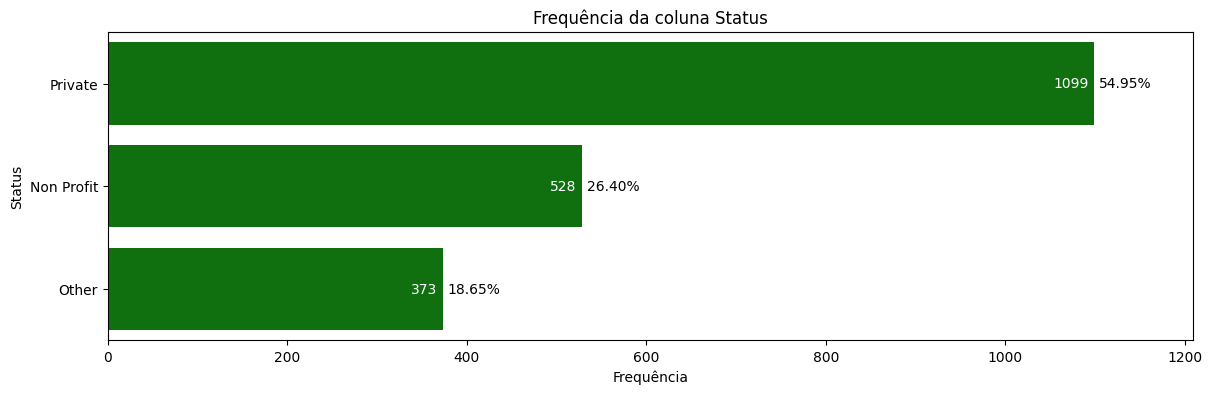

In [15]:
barplot(test_df['Status'])

In [16]:
# Split the data into X (features) and y (labels)
X_train = train_df.drop(['Value', 'Website'], axis=1)
y_train = train_df[['Value']]
X_test = test_df.drop(['Value', 'Website'], axis=1)

# Define the OneHotEncoder for the categorical columns
ct = ColumnTransformer(
    [('encoder', OneHotEncoder(handle_unknown='ignore'), ['City', 'Revenue', 'Status'])],
    remainder='passthrough')

# Define the pipeline with KMeans
pipeline = Pipeline([
    ('transform', ct),
    ('kmeans', KMeans(n_clusters=2, random_state=42))
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'kmeans__n_clusters': [2],
    'kmeans__init': ['k-means++', 'random'],
    'kmeans__max_iter': [100, 200, 300],
    'kmeans__tol': [0.0001, 0.001, 0.01]
}

# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Use the best model to predict missing 'Status' and 'Value' values in the test set
y_pred = grid_search.predict(X_test)

# Create a new dataframe with the predicted 'Status' and 'Value' values
result_df = pd.DataFrame(y_pred, columns=['Value'])

# Merge the original test dataframe with the predicted values dataframe using the index
test_df = pd.concat([test_df.drop(['Value'], axis=1), result_df], axis=1)

# Print the resulting dataframe with filled 'Status' and 'Value' values
print(test_df)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
               City                                            Website  \
0            Denver                            https://mysunshare.com/   
1      Yucca Valley                               http://prototyp3.xyz   
2          New York                                  http://onyllc.com   
3        Wilmington                           http://www.nikangtx.com/   
4       Kansas City                             http://www.dtpizza.org   
...             ...                                                ...   
1995          Miami                            https://swapglobal.com/   
1996        Concord                      https://www.kantumpharma.com/   
1997        Houston  https://www.mydna.life/gene-by-gene-familytree...   
1998  Santa Clarita                      http://www.blackknightllc.com   
1999         Tucson                              https://tetakawi.com/   

                          Revenue      Status  Val

Mostrando as maiores categorias de 909


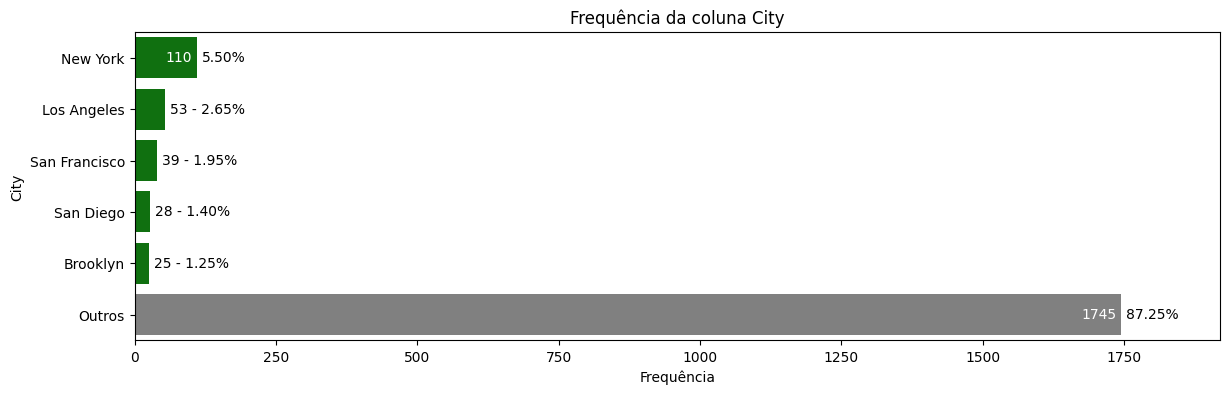

Mostrando as maiores categorias de 1997


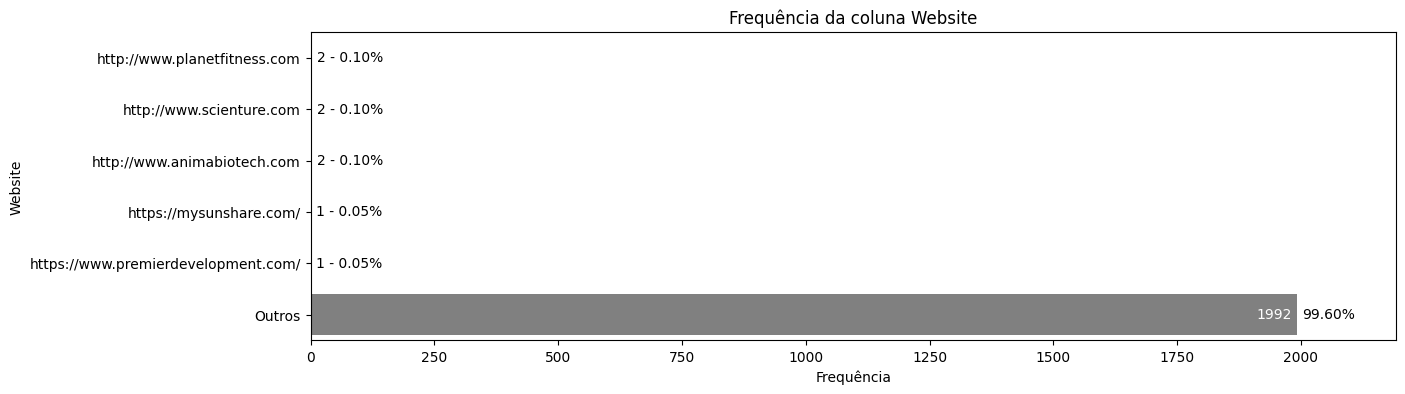

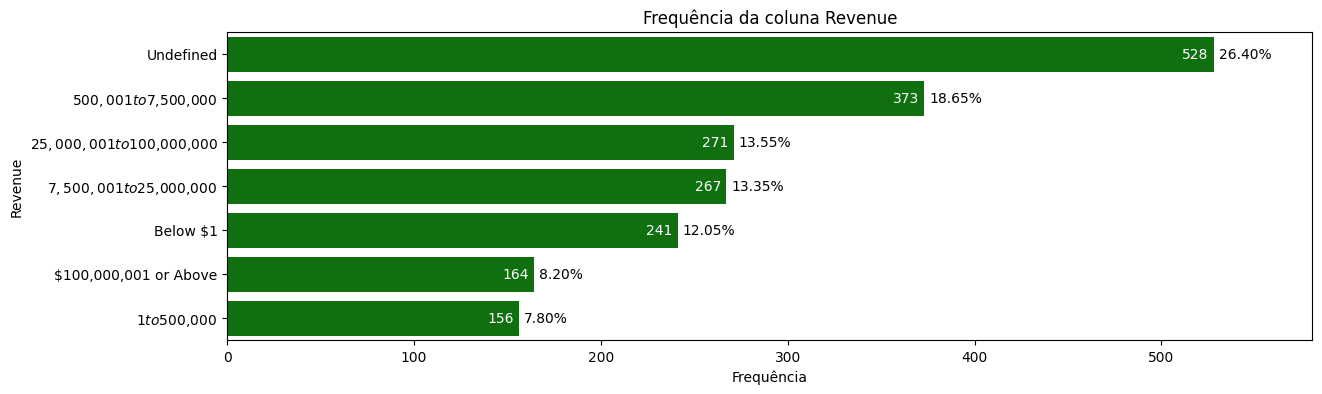

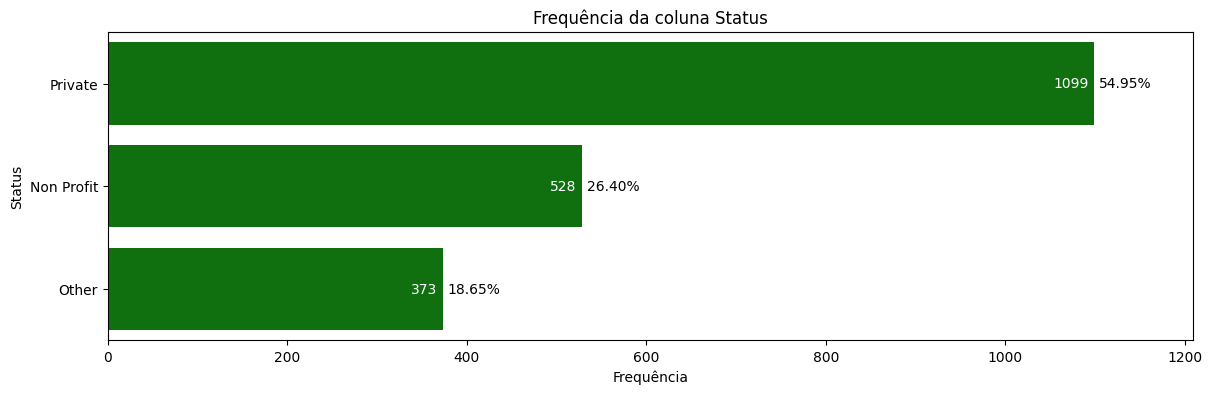

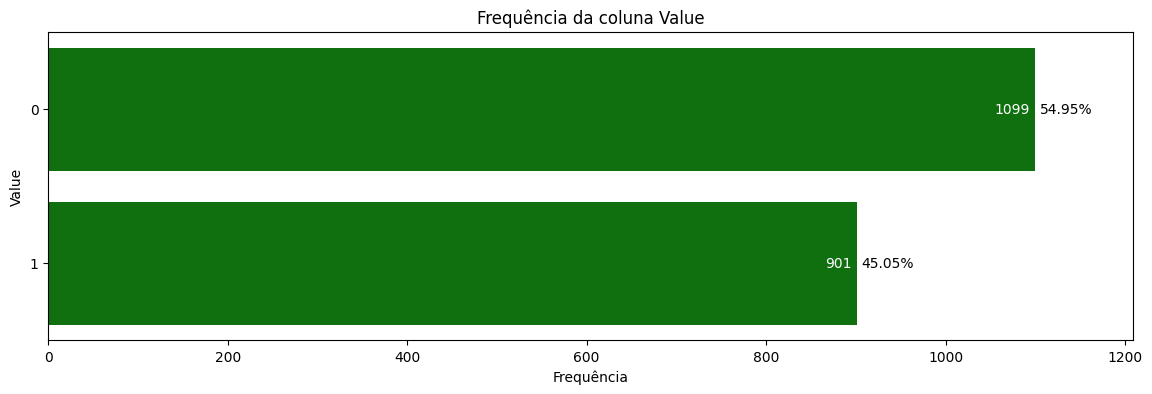

In [18]:
for colunas in test_df.columns:
    barplot(test_df[colunas])

In [19]:
test_df.shape

(2000, 5)

In [20]:
test_df.to_csv(DATA_PATH / 'testing_filled_2.csv')

My strategy was:
    1) Find exact "City" and "Revenue" matches in both dataframe, then fill testing df accordingly
    2) Now, we have a bigger training set, and we train a clustering (kmeans) algorithm first to the "Status" column, to fill it in the test df.
    3) With "Status" filled, we do the same for the "Value" column.
